# Fruits fresh and rotten for classification

En este proyecto lo que se piensa hacer es entrenar un modelo que pueda reconocer frutas podridas y frescas. Hay 6 categorias de frutas manzanas frescas, platanos frescos, naranjas frescas, manzanas podridas, platanos podridos y naranja podridas.

In [ ]:
# Importamos las librerías

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import os
import pandas as pd

### Explorado el dataset

In [25]:
trn_images = []
trn_labels = []


for category in os.listdir("data/train/"):
    if os.path.isdir("data/train/%s" % (category)):
        for img in os.listdir("data/train/%s" % (category)):
            if img.endswith(".png"):
                trn_images.append("data/train/%s/%s" % (category, img))
                trn_labels.append("%s" % (category))

In [26]:
dataset = pd.DataFrame({"images": trn_images, "labels": trn_labels})

grouped = dataset.groupby("labels")
grouped.count()

,images
labels,
freshapples,1693
freshbanana,1581
freshoranges,1466
rottenapples,2342
rottenbanana,2224
rottenoranges,1595


In [27]:
def view_random_imgs(dir_name, label):
    random_images = random.choices(os.listdir(f'./{dir_name}/{label}'), k=10)
    plt.figure(figsize=(15, 10))

    for i, img in enumerate(random_images):
        plt.subplot(5, 5, i+1)
        img = keras.utils.load_img(f'./{dir_name}/{label}/{img}')
        plt.title(label)
        plt.imshow(img)
        plt.axis(False)

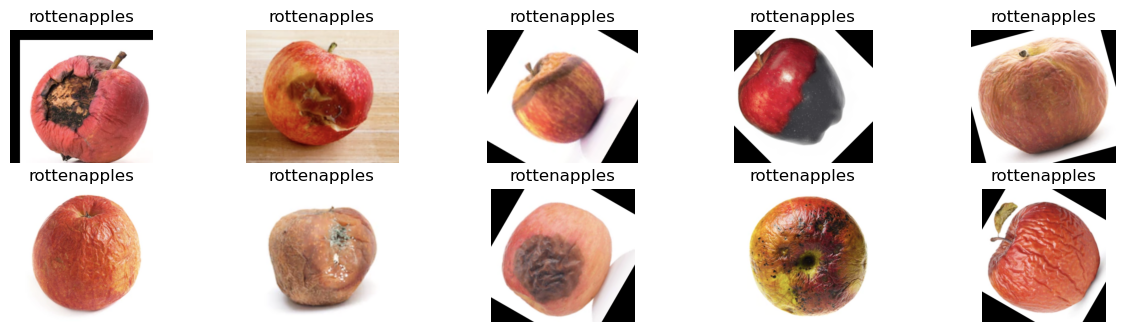

In [28]:
view_random_imgs(dir_name='data/train', label='rottenapples')

### Preparando los datos para el modelo

In [29]:
contenido = os.listdir('data/train')
contenido.sort()
files = contenido
files


['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [30]:
imgs = []
for f in files:
    imgs += os.listdir('data/train/' + f)
    
imgs[:3]

['rotated_by_15_Screen Shot 2018-06-08 at 4.59.36 PM.png',
 'rotated_by_15_Screen Shot 2018-06-08 at 4.59.44 PM.png',
 'rotated_by_15_Screen Shot 2018-06-08 at 4.59.57 PM.png']

In [31]:
from keras.applications import VGG16
  
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")

In [32]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

In [33]:
import keras.utils as image_utils
from keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

In [34]:
processed_image = load_and_process_image("data/train/freshapples/Screen Shot 2018-06-08 at 4.59.36 PM.png")

Original image shape:  (476, 458, 4)
Processed image shape:  (1, 224, 224, 3)


In [35]:
from keras.applications.vgg16 import decode_predictions

In [36]:
def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(476, 458, 4)
Original image shape:  (476, 458, 4)
Processed image shape:  (1, 224, 224, 3)
1/1 [==============================] - 3s 3s/step
Predicted: [[('n07768694', 'pomegranate', 0.8191581), ('n07745940', 'strawberry', 0.048739616), ('n07742313', 'Granny_Smith', 0.03488835)]]


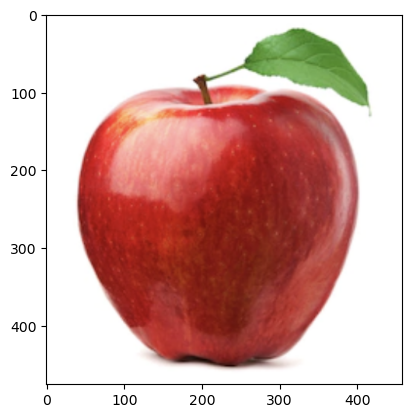

In [37]:
readable_prediction("data/train/freshapples/Screen Shot 2018-06-08 at 4.59.36 PM.png")

### Cargando ImageNet como modelo base

Iniciamos con un modelo pre entrenado en ImageNet.

In [38]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [39]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Congelamos el modelo base, con el objetivo de no eliminar el entrenamiento inicial con el conjunto de datos ImageNet

In [40]:
# Freeze model base
base_model.trainable = False

Agregamos más capas al modelo pre-entrenado

In [41]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(6, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


Compilar modelo con los parámetros de métricas y función de pérdida.

In [43]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), metrics=[keras.metrics.CategoricalAccuracy()])

### Aumentamos la data
Incrementamos la cantidad  de data para mejorar el dataset.

In [44]:
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

### Cargamos el dataset

In [45]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('data/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode="categorical")
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('data/valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


### Entrenamos el modelo

In [46]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=20)

Epoch 1/20
340/340 [==============================] - 414s 1s/step - loss: 0.6997 - categorical_accuracy: 0.8163 - val_loss: 0.1809 - val_categorical_accuracy: 0.9337
Epoch 2/20
340/340 [==============================] - 203s 595ms/step - loss: 0.1378 - categorical_accuracy: 0.9528 - val_loss: 0.1197 - val_categorical_accuracy: 0.9644
Epoch 3/20
340/340 [==============================] - 189s 555ms/step - loss: 0.0897 - categorical_accuracy: 0.9696 - val_loss: 0.0987 - val_categorical_accuracy: 0.9644
Epoch 4/20
340/340 [==============================] - 182s 535ms/step - loss: 0.0694 - categorical_accuracy: 0.9751 - val_loss: 0.0679 - val_categorical_accuracy: 0.9789
Epoch 5/20
340/340 [==============================] - 169s 496ms/step - loss: 0.0591 - categorical_accuracy: 0.9802 - val_loss: 0.0592 - val_categorical_accuracy: 0.9796
Epoch 6/20
340/340 [==============================] - 771s 2s/step - loss: 0.0522 - categorical_accuracy: 0.9821 - val_loss: 0.0462 - val_categorical_acc

### Descongelamos el modelo y lo volvemos a entrenar

In [47]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=False) , metrics = [keras.metrics.CategoricalAccuracy()])

In [50]:
history = model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=10)

Epoch 1/10
340/340 [==============================] - 192s 561ms/step - loss: 0.0026 - categorical_accuracy: 0.9994 - val_loss: 1.7294e-04 - val_categorical_accuracy: 1.0000
Epoch 2/10
340/340 [==============================] - 219s 641ms/step - loss: 0.0033 - categorical_accuracy: 0.9993 - val_loss: 9.1984e-04 - val_categorical_accuracy: 0.9996
Epoch 3/10
340/340 [==============================] - 251s 736ms/step - loss: 0.0026 - categorical_accuracy: 0.9994 - val_loss: 0.0161 - val_categorical_accuracy: 0.9956
Epoch 4/10
340/340 [==============================] - 271s 795ms/step - loss: 0.0052 - categorical_accuracy: 0.9986 - val_loss: 0.0017 - val_categorical_accuracy: 0.9989
Epoch 5/10
340/340 [==============================] - 259s 759ms/step - loss: 0.0012 - categorical_accuracy: 0.9998 - val_loss: 5.5824e-04 - val_categorical_accuracy: 0.9996
Epoch 6/10
340/340 [==============================] - 252s 739ms/step - loss: 0.0017 - categorical_accuracy: 0.9997 - val_loss: 0.0021 - v

### Evaluación del modelo

In [51]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

84/84 [==============================] - 41s 480ms/step - loss: 3.4233e-06 - categorical_accuracy: 1.0000


[3.423309863137547e-06, 1.0]

### Graficamos las curvas de entrenamiento y validación

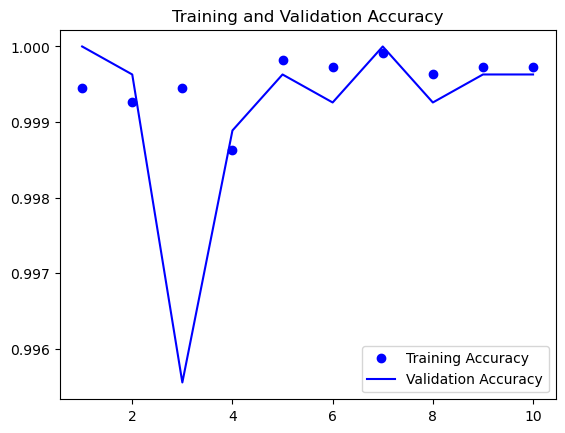

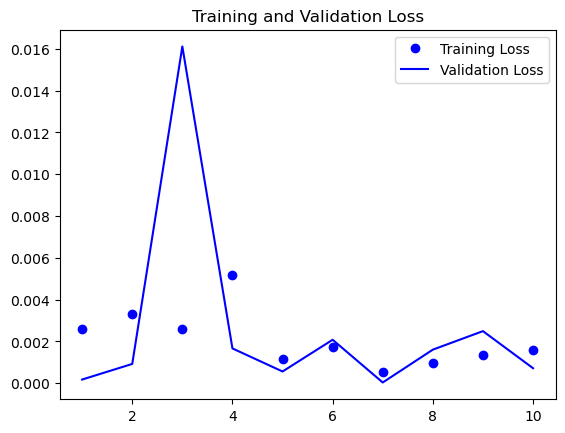

In [53]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()